In [ ]:
!git clone https://github.com/mf1024/ImageNet-Datasets-Downloader.git


Cloning into 'ImageNet-Datasets-Downloader'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 127 (delta 4), reused 6 (delta 2), pack-reused 113
Receiving objects: 100% (127/127), 1.58 MiB | 25.61 MiB/s, done.
Resolving deltas: 100% (68/68), done.


In [ ]:
%cd ImageNet-Datasets-Downloader/


/content/ImageNet-Datasets-Downloader


In [ ]:
!python ./downloader.py \
    -data_root /content/sample_data \
    -use_class_list True \
    -class_list n02133161 \
    -images_per_class 50


Picked the following clases:
['American black bear']
Scraping images for class "American black bear"
Multiprocessing workers: 8


In [ ]:
pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38262 sha256=360dfdf63c43794a397941bad9a3d1e0346bcb5064f580c96443c1b79805f08e
  Stored in directory: /root/.cache/pip/wheels/3c/6c/04/9a543775e9f25f6c441180a552456f1696167439459730ff87
Successfully built grad-cam


In [ ]:
pip install --upgrade torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 361MB/s]


<class 'pytorch_grad_cam.grad_cam.GradCAM'>


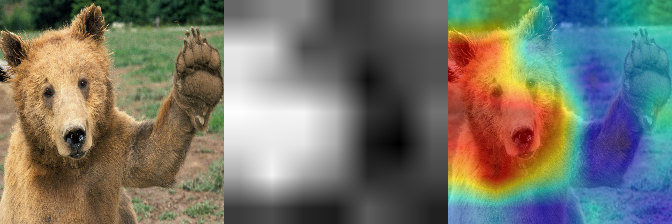

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import cv2
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image

model = models.resnet50(pretrained=True)
model.eval()
image_url = "https://th.bing.com/th/id/R.94b33a074b9ceeb27b1c7fba0f66db74?rik=wN27mvigyFlXGg&riu=http%3a%2f%2fimages5.fanpop.com%2fimage%2fphotos%2f31400000%2fBear-Wallpaper-bears-31446777-1600-1200.jpg&ehk=oD0JPpRVTZZ6yizZtGQtnsBGK2pAap2xv3sU3A4bIMc%3d&risl=&pid=ImgRaw&r=0"
img = np.array(Image.open(requests.get(image_url, stream=True).raw))
# img = cv2.imread('cam3.jpeg')
# img = cv2.imread('/content/cam5.jpg')
# img = cv2.imread('/content/mb.jpg')
# img = cv2.imread('/content/4.jpg')
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# The target for the CAM is the Bear category.
# As usual for classication, the target is the logit output
# before softmax, for that category.
targets = [ClassifierOutputTarget(295)]
target_layers = [model.layer4]
with GradCAM(model=model, target_layers=target_layers) as cam:
    print(type(cam))
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)

The confidence increase percent: 0.005074194632470608
The visualization of the pertubated image for the metric:


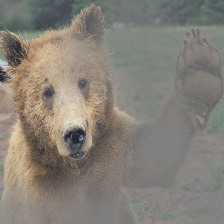

In [ ]:
# Now lets see how to evaluate this explanation:
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget

# For the metrics we want to measure the change in the confidence, after softmax, that's why
# we use ClassifierOutputSoftmaxTarget.
targets = [ClassifierOutputSoftmaxTarget(295)]
cam_metric = CamMultImageConfidenceChange()
scores, visualizations = cam_metric(input_tensor, grayscale_cams, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase percent: {100*score}")
print("The visualization of the pertubated image for the metric:")
Image.fromarray(visualization)

The confidence increase here is positive.

That's a good sign - the CAM reduced noise from other parts of the image and retains the information that triggers the category output.

- The "drop in confidence" metric here from the gradcam++ paper would be 0 (since it's negative).
- The "increase in confidence" metric would be 1 (since there is an increase in confidence).
For completeness, lets see how we can use those metrics directly:

In [ ]:
from pytorch_grad_cam.metrics.cam_mult_image import DropInConfidence, IncreaseInConfidence
print("Drop in confidence", DropInConfidence()(input_tensor, grayscale_cams, targets, model))
print("Increase in confidence", IncreaseInConfidence()(input_tensor, grayscale_cams, targets, model))

Drop in confidence [0.]
Increase in confidence [1.]


Similarly, we could pertubate the image by deleting pixels with high values in the CAM.
In this case, we would WANT a larger drop in the confidence.

The confidence increase percent: -0.00022309657651931047
The visualization of the pertubated image for the metric:


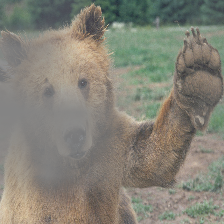

In [ ]:
inverse_cams = 1 - grayscale_cams
scores, visualizations = CamMultImageConfidenceChange()(input_tensor, inverse_cams, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase percent: {score}")
print("The visualization of the pertubated image for the metric:")
Image.fromarray(visualization)

The confidence increase: -0.0015226600226014853
The visualization of the pertubated image for the metric:


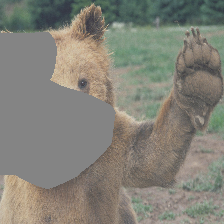

In [ ]:
thresholded_cam = grayscale_cams < np.percentile(grayscale_cams, 75)
scores, visualizations = CamMultImageConfidenceChange()(input_tensor, thresholded_cam, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase: {score}")
print("The visualization of the pertubated image for the metric:")
Image.fromarray(visualization)

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
def f1(img):
  img = cv2.resize(img, (224, 224))
  cv2_imshow(img)
  img = np.float32(img) / 255
  
  input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# The target for the CAM is the Bear category.
# As usual for classication, the target is the logit output
# before softmax, for that category.
  targets = [ClassifierOutputTarget(295)]
  target_layers = [model.layer4]
  with GradCAM(model=model, target_layers=target_layers) as cam:
      print(type(cam))
      grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
      cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
  thresholded_cam = grayscale_cams < np.percentile(grayscale_cams, 75)
  scores, visualizations = CamMultImageConfidenceChange()(input_tensor, thresholded_cam, targets, model, return_visualization=True)
  score = scores[0]
  visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
  visualization = deprocess_image(visualization)
  print(f"The confidence increase: {score}")
  print("The visualization of the pertubated image for the metric:")
  cv2_imshow(visualization)
  return score


In [ ]:
import os 

In [ ]:
# Path to the folder containing images
folder_path = '/content/sample_data/imagenet_images/American black bear'
score_list_gp = []
# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        # Load the image
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)

        # Apply the function to the image
        score= f1(img)
        score_list_gp.append(score)

<class 'pytorch_grad_cam.grad_cam.GradCAM'>


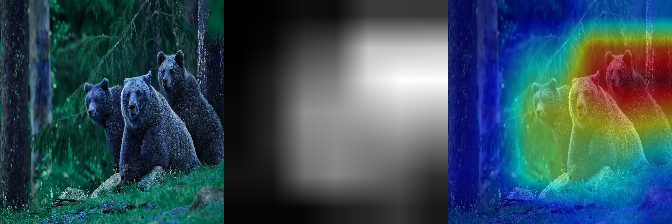

In [ ]:
#For Multiple Objects Image : 
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import cv2
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image

model = models.resnet50(pretrained=True)

img = cv2.imread('/content/cam5.jpg')

img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# The target for the CAM is the Bear category.
# As usual for classication, the target is the logit output
# before softmax, for that category.
targets = [ClassifierOutputTarget(295)]
target_layers = [model.layer4]
with GradCAM(model=model, target_layers=target_layers) as cam:
    print(type(cam))
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)

The confidence increase: -7.43841028213501
The visualization of the pertubated image for the metric:


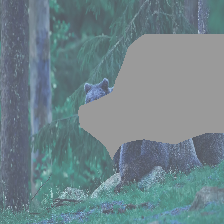

In [ ]:
thresholded_cam = grayscale_cams < np.percentile(grayscale_cams, 75)
scores, visualizations = CamMultImageConfidenceChange()(input_tensor, thresholded_cam, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase: {score}")
print("The visualization of the pertubated image for the metric:")
Image.fromarray(visualization)

#grad_cam++

<class 'pytorch_grad_cam.grad_cam_plusplus.GradCAMPlusPlus'>


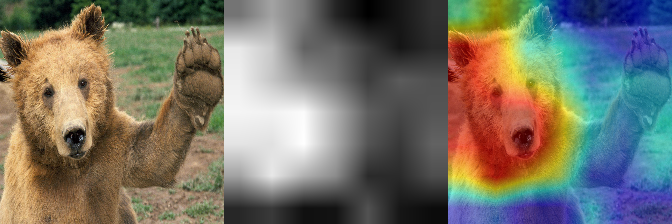

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import cv2
import requests
from pytorch_grad_cam import GradCAM,GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image

model = models.resnet50(pretrained=True)
model.eval()
image_url = "https://th.bing.com/th/id/R.94b33a074b9ceeb27b1c7fba0f66db74?rik=wN27mvigyFlXGg&riu=http%3a%2f%2fimages5.fanpop.com%2fimage%2fphotos%2f31400000%2fBear-Wallpaper-bears-31446777-1600-1200.jpg&ehk=oD0JPpRVTZZ6yizZtGQtnsBGK2pAap2xv3sU3A4bIMc%3d&risl=&pid=ImgRaw&r=0"
img = np.array(Image.open(requests.get(image_url, stream=True).raw))
# img = cv2.imread('/content/4.jpg')
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# The target for the CAM is the Bear category.
# As usual for classication, the target is the logit output
# before softmax, for that category.
targets = [ClassifierOutputTarget(295)]
target_layers = [model.layer4]
with GradCAMPlusPlus(model=model, target_layers=target_layers) as cam:
    print(type(cam))
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)

The confidence increase percent: -0.060465128626674414
The visualization of the pertubated image for the metric:


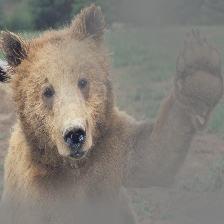

In [ ]:
# Now lets see how to evaluate this explanation:
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget

# For the metrics we want to measure the change in the confidence, after softmax, that's why
# we use ClassifierOutputSoftmaxTarget.
targets = [ClassifierOutputSoftmaxTarget(295)]
cam_metric = CamMultImageConfidenceChange()
scores, visualizations = cam_metric(input_tensor, grayscale_cams, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase percent: {100*score}")
print("The visualization of the pertubated image for the metric:")
Image.fromarray(visualization)

The confidence increase percent: -0.0011541853891685605
The visualization of the pertubated image for the metric:


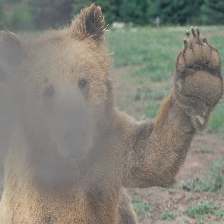

In [ ]:
inverse_cams = 1 - grayscale_cams
scores, visualizations = CamMultImageConfidenceChange()(input_tensor, inverse_cams, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase percent: {score}")
print("The visualization of the pertubated image for the metric:")
Image.fromarray(visualization)

The confidence increase: -0.0015253899618983269
The visualization of the pertubated image for the metric:


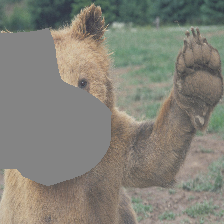

In [ ]:
thresholded_cam = grayscale_cams < np.percentile(grayscale_cams, 75)
scores, visualizations = CamMultImageConfidenceChange()(input_tensor, thresholded_cam, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase: {score}")
print("The visualization of the pertubated image for the metric:")
Image.fromarray(visualization)

In [ ]:
def f2(img):
  img = cv2.resize(img, (224, 224))
  cv2_imshow(img)
  img = np.float32(img) / 255
  
  input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# The target for the CAM is the Bear category.
# As usual for classication, the target is the logit output
# before softmax, for that category.
  targets = [ClassifierOutputTarget(295)]
  target_layers = [model.layer4]
  with GradCAMPlusPlus(model=model, target_layers=target_layers) as cam:
      print(type(cam))
      grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
      cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
  thresholded_cam = grayscale_cams < np.percentile(grayscale_cams, 75)
  scores, visualizations = CamMultImageConfidenceChange()(input_tensor, thresholded_cam, targets, model, return_visualization=True)
  score = scores[0]
  visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
  visualization = deprocess_image(visualization)
  print(f"The confidence increase: {score}")
  print("The visualization of the pertubated image for the metric:")
  cv2_imshow(visualization)
  return score


In [ ]:
# Path to the folder containing images
folder_path = '/content/sample_data/imagenet_images/American black bear'
score_list_gcampp = []
# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        # Load the image
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)

        # Apply the function to the image
        score= f2(img)
        score_list_gcampp.append(score)

<class 'pytorch_grad_cam.grad_cam_plusplus.GradCAMPlusPlus'>


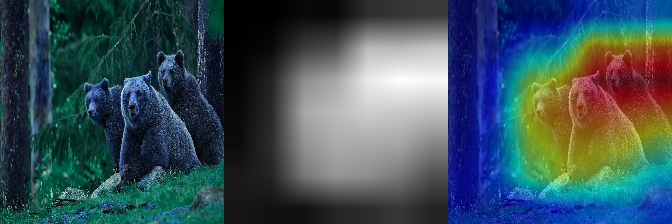

In [ ]:
model = models.resnet50(pretrained=True)

img = cv2.imread('/content/cam5.jpg')

img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# The target for the CAM is the Bear category.
# As usual for classication, the target is the logit output
# before softmax, for that category.
targets = [ClassifierOutputTarget(295)]
target_layers = [model.layer4]
with GradCAMPlusPlus(model=model, target_layers=target_layers) as cam:
    print(type(cam))
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)

The confidence increase: -9.312496185302734
The visualization of the pertubated image for the metric:


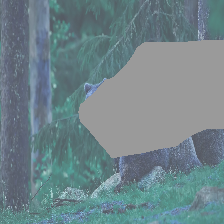

In [ ]:
thresholded_cam = grayscale_cams < np.percentile(grayscale_cams, 75)
scores, visualizations = CamMultImageConfidenceChange()(input_tensor, thresholded_cam, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase: {score}")
print("The visualization of the pertubated image for the metric:")
Image.fromarray(visualization)

#Mean Drop Value over a DataSet of 100 images

In [ ]:
len(score_list_gp)

54

In [ ]:
len(score_list_gcampp)

54

In [ ]:
# Average Value of confidencee drop for gradCAM over the images : 
print(np.mean(score_list_gp),'%')

-9.37051 %


In [ ]:
# Average Value of confidencee drop for gradCAM++ over the images : 
print(np.mean(score_list_gcampp),'%')

-9.441902 %


#Method 3 -IoU with ground truth Bounding Box 

#GradCAM

<class 'pytorch_grad_cam.grad_cam.GradCAM'>


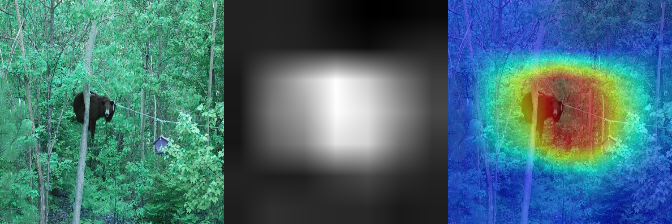

In [ ]:
model = models.resnet50(pretrained=True)

img = cv2.imread('/content/bb18b204-25c1-43ae-81a8-e45f424e94ac.jpg')

img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# The target for the CAM is the Bear category.
# As usual for classication, the target is the logit output
# before softmax, for that category.
targets = [ClassifierOutputTarget(295)]
target_layers = [model.layer4]
with GradCAM(model=model, target_layers=target_layers) as cam:
    print(type(cam))
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)

The confidence increase: -8.299992561340332
The visualization of the pertubated image for the metric:


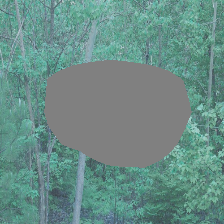

In [ ]:
thresholded_cam = grayscale_cams < np.percentile(grayscale_cams, 75)
scores, visualizations = CamMultImageConfidenceChange()(input_tensor, thresholded_cam, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase: {score}")
print("The visualization of the pertubated image for the metric:")
Image.fromarray(visualization)

In [ ]:
visualization[120,120]

array([128, 128, 128], dtype=uint8)

In [ ]:
# Find the indices of the pixels with RGB values [132, 132, 132]
indices = np.where(np.all(visualization == [128,128,128], axis=-1))

# Find the top-most, bottom-most, left-most, and right-most pixel locations
top, left = np.min(indices, axis=1)
bottom, right = np.max(indices, axis=1)

# Print the results
print(f'Top: {top}, Left: {left}, Bottom: {bottom}, Right: {right}')

Top: 60, Left: 44, Bottom: 167, Right: 191


In [ ]:
center_x = (left+right)/2
center_y = (top+bottom)/2
height = bottom - top
width = right - left

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

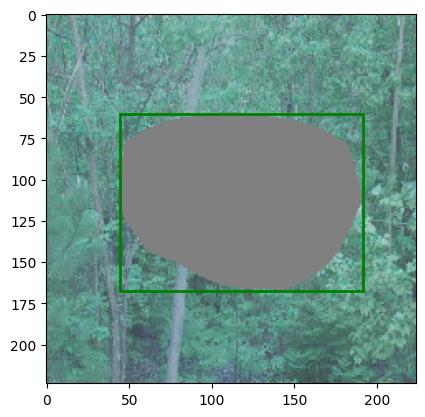

In [ ]:
# Calculate the top-left and bottom-right corner coordinates of the bounding box
half_height = height // 2
half_width = width // 2
top_left_x = center_x - half_width
top_left_y = center_y - half_height
bottom_right_x = center_x + half_width
bottom_right_y = center_y + half_height

# Create a figure and axes object
fig, ax = plt.subplots(1)

# Display the image
ax.imshow(visualization)

# Create a rectangle patch object
bbox = patches.Rectangle((top_left_x, top_left_y), width, height, linewidth=2, edgecolor='g', facecolor='none')

# Add the rectangle patch to the axes object
ax.add_patch(bbox)

# Show the plot
plt.show()

In [ ]:
def bbox_to_coords(center_x, center_y, width, height):
    x1 = int(center_x - width/2)
    y1 = int(center_y - height/2)
    x2 = int(center_x + width/2)
    y2 = int(center_y + height/2)
    return (x1, y1, x2, y2)



In [ ]:
bbox1 = bbox_to_coords(center_x,center_y,width,height)


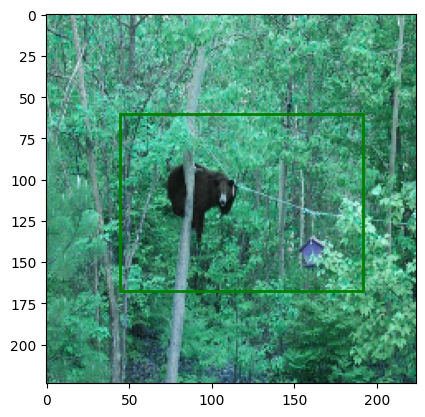

In [ ]:
# Create a figure and axes object
fig, ax = plt.subplots(1)

# Display the image
ax.imshow(img)

# Create a rectangle patch object
bbox = patches.Rectangle((top_left_x, top_left_y), width, height, linewidth=2, edgecolor='g', facecolor='none')

# Add the rectangle patch to the axes object
ax.add_patch(bbox)

# Show the plot
plt.show()

#Creating Manual Ground Truth for now : 

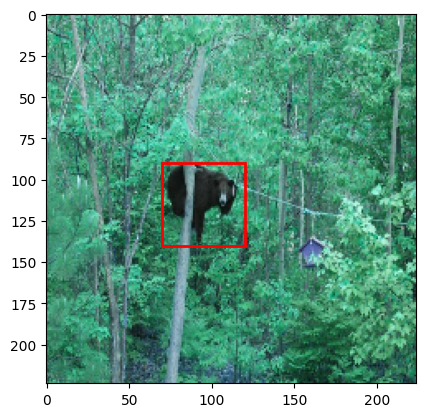

In [ ]:
# Create a figure and axes object
fig, ax = plt.subplots(1)

# Display the image
ax.imshow(img)

# Create a rectangle patch object
bbox = patches.Rectangle((70, 90), 50,50, linewidth=2, edgecolor='r', facecolor='none')

# Add the rectangle patch to the axes object
ax.add_patch(bbox)

# Show the plot
plt.show()
width = 75 
height = 170 
center_x = 72 + 37
center_y = 30 + 85

In [ ]:
bbox2 =  bbox_to_coords(center_x,center_y,width,height)

In [ ]:
def calculate_iou(bbox1, bbox2):
    # Calculate the intersection coordinates
    x1 = max(bbox1[0], bbox2[0])
    y1 = max(bbox1[1], bbox2[1])
    x2 = min(bbox1[2], bbox2[2])
    y2 = min(bbox1[3], bbox2[3])

    # Calculate the intersection area
    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

    # Calculate the union area
    bbox1_area = (bbox1[2] - bbox1[0] + 1) * (bbox1[3] - bbox1[1] + 1)
    bbox2_area = (bbox2[2] - bbox2[0] + 1) * (bbox2[3] - bbox2[1] + 1)
    union_area = bbox1_area + bbox2_area - intersection_area

    # Calculate the IoU value
    iou = intersection_area / union_area
    return iou

In [ ]:
print('The meanIoU value between ground truth and bounding box from CAM is :',calculate_iou(bbox1,bbox2))

The meanIoU value between ground truth and bounding box from CAM is : 0.3951473136915078


<class 'pytorch_grad_cam.grad_cam_plusplus.GradCAMPlusPlus'>


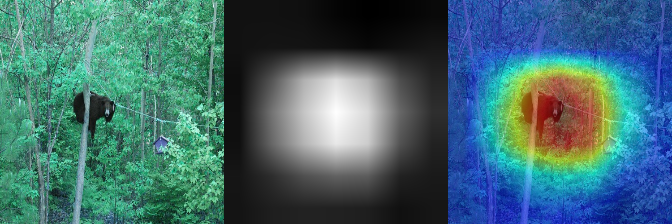

In [ ]:
model = models.resnet50(pretrained=True)

img = cv2.imread('/content/bb18b204-25c1-43ae-81a8-e45f424e94ac.jpg')

img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# The target for the CAM is the Bear category.
# As usual for classication, the target is the logit output
# before softmax, for that category.
targets = [ClassifierOutputTarget(295)]
target_layers = [model.layer4]
with GradCAMPlusPlus(model=model, target_layers=target_layers) as cam:
    print(type(cam))
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)

The confidence increase: -6.847492218017578
The visualization of the pertubated image for the metric:


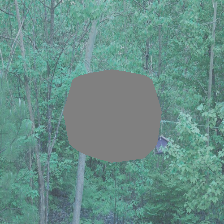

In [ ]:
thresholded_cam = grayscale_cams < np.percentile(grayscale_cams, 85)
scores, visualizations = CamMultImageConfidenceChange()(input_tensor, thresholded_cam, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase: {score}")
print("The visualization of the pertubated image for the metric:")
Image.fromarray(visualization)

In [ ]:
visualization[140,130]

array([128, 128, 128], dtype=uint8)

In [ ]:
# Find the indices of the pixels with RGB values [132, 132, 132]
indices = np.where(np.all(visualization == [128, 128, 128], axis=-1))

# Find the top-most, bottom-most, left-most, and right-most pixel locations
top, left = np.min(indices, axis=1)
bottom, right = np.max(indices, axis=1)

# Print the results
print(f'Top: {top}, Left: {left}, Bottom: {bottom}, Right: {right}')

Top: 69, Left: 63, Bottom: 162, Right: 161


In [ ]:
center_x = (left+right)/2
center_y = (top+bottom)/2
height = bottom - top
width = right - left

In [ ]:
bbox1 = bbox_to_coords(center_x,center_y,width,height)


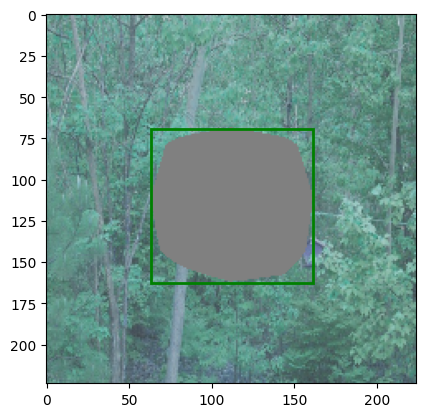

In [ ]:
# Calculate the top-left and bottom-right corner coordinates of the bounding box
half_height = height // 2
half_width = width // 2
top_left_x = center_x - half_width
top_left_y = center_y - half_height
bottom_right_x = center_x + half_width
bottom_right_y = center_y + half_height

# Create a figure and axes object
fig, ax = plt.subplots(1)

# Display the image
ax.imshow(visualization)

# Create a rectangle patch object
bbox = patches.Rectangle((top_left_x, top_left_y), width, height, linewidth=2, edgecolor='g', facecolor='none')

# Add the rectangle patch to the axes object
ax.add_patch(bbox)

# Show the plot
plt.show()

In [ ]:
print('The IoU value between ground truth and bounding box from CAM is :',calculate_iou(bbox1,bbox2))

The IoU value between ground truth and bounding box from CAM is : 0.47130228262303736


# CAM 

In [ ]:
!pip install torchvision matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install torchcam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 MB 637.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.6 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.15.1+cu118 requires torch==2.0.0, but you have torch 1.13.1 which is incompatible.
torchtext 0.15.1 requires torch==2.0.0, but you have torch

In [ ]:
import torchcam

In [ ]:
import torchcam.metrics
import torchcam.methods
import torchcam.utils

In [ ]:
# Install the most up-to-date version from GitHub
!pip install -e git+https://github.com/frgfm/torch-cam.git#egg=torchcam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining torchcam from git+https://github.com/frgfm/torch-cam.git#egg=torchcam
  Updating ./src/torchcam clone
  Running command git fetch -q --tags
  Running command git reset --hard -q c24a85836d19fecc2a00def4c95ad903e225d612
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for torchcam (pyproject.toml) ... done
  Created wheel for torchcam: filename=torchcam-0.4.0.dev0-0.editable-py3-none-any.whl size=16054 sha256=ac2871492b9fcd48cbc05d85067a350ab1a47188c56435763f55b07bd19256a7
  Stored in directory: /tmp/pip-ephem-wheel-cache-0rk9ncqd/wheels/e6/c4/45/1e8ecc7d7013425db179423e05fdfc5b61139cf8a8b5f6dedc
Successfully built torchcam
  Attempting uninstall: torchcam
    Found existing installation: torchcam 0.4.0.

In [ ]:
%matplotlib inline
# All imports
import matplotlib.pyplot as plt
import torch
from torch.nn.functional import softmax, interpolate
from torchvision.io.image import read_image
from torchvision.models import resnet18
from torchvision.transforms.functional import normalize, resize, to_pil_image

from torchcam.methods import CAM,SmoothGradCAMpp
from torchcam.utils import overlay_mask

In [ ]:
# Download an image
!wget https://th.bing.com/th/id/R.94b33a074b9ceeb27b1c7fba0f66db74?rik=wN27mvigyFlXGg&riu=http%3a%2f%2fimages5.fanpop.com%2fimage%2fphotos%2f31400000%2fBear-Wallpaper-bears-31446777-1600-1200.jpg&ehk=oD0JPpRVTZZ6yizZtGQtnsBGK2pAap2xv3sU3A4bIMc%3d&risl=&pid=ImgRaw&r=0
# Set this to your image path if you wish to run it on your own data
img_path = "/content/bear.jpg"

--2023-04-24 06:07:59--  https://th.bing.com/th/id/R.94b33a074b9ceeb27b1c7fba0f66db74?rik=wN27mvigyFlXGg
Resolving th.bing.com (th.bing.com)... 204.79.197.200, 13.107.21.200, 2620:1ec:c11::200
Connecting to th.bing.com (th.bing.com)|204.79.197.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 337749 (330K) [image/jpeg]
Saving to: ‘R.94b33a074b9ceeb27b1c7fba0f66db74?rik=wN27mvigyFlXGg.8’

R.94b33a074b9ceeb27 100%[===================>] 329.83K  --.-KB/s    in 0.05s   

2023-04-24 06:07:59 (6.33 MB/s) - ‘R.94b33a074b9ceeb27b1c7fba0f66db74?rik=wN27mvigyFlXGg.8’ saved [337749/337749]



In [ ]:
import numpy as np
import cv2
from torchvision import transforms

In [ ]:
# Instantiate your model here
model = resnet18(pretrained=True).eval()
cam_extractor = SmoothGradCAMpp(model)
# Get your input
# image_url = "https://th.bing.com/th/id/R.94b33a074b9ceeb27b1c7fba0f66db74?rik=wN27mvigyFlXGg&riu=http%3a%2f%2fimages5.fanpop.com%2fimage%2fphotos%2f31400000%2fBear-Wallpaper-bears-31446777-1600-1200.jpg&ehk=oD0JPpRVTZZ6yizZtGQtnsBGK2pAap2xv3sU3A4bIMc%3d&risl=&pid=ImgRaw&r=0"
# img = np.array(Image.open(requests.get(image_url, stream=True).raw))
img = cv2.imread('cam3.jpeg')
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255

input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# # Preprocess it for your chosen model
# input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Preprocess your data and feed it to the model
out = model(input_tensor)
# Retrieve the CAM by passing the class index and the model output
cams = cam_extractor(out.squeeze(0).argmax().item(), out)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
# Notice that there is one CAM per target layer (here only 1)
for cam in cams:
  print(cam.shape)

torch.Size([1, 7, 7])


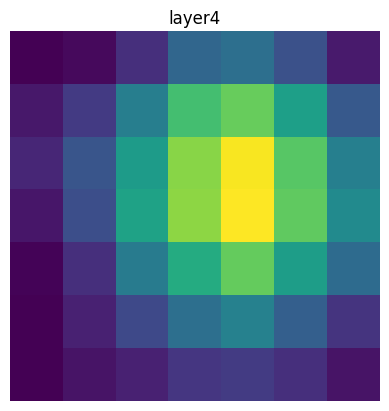

In [ ]:
# The raw CAM
for name, cam in zip(cam_extractor.target_names, cams):
  plt.imshow(cam.squeeze(0).numpy()); plt.axis('off'); plt.title(name); plt.show()

In [ ]:
len(cams)

1

In [ ]:
import numpy as np
import torch

# assume img is a numpy ndarray with shape (height, width, channels)
img = torch.from_numpy(np.transpose(img, (2, 0, 1))).float()


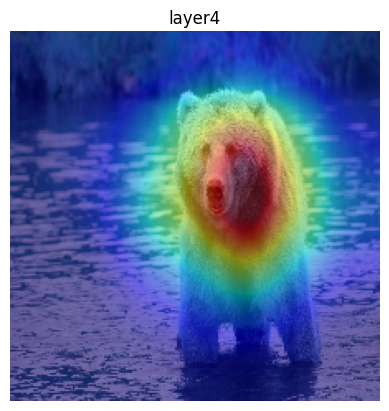

In [ ]:
# Overlayed on the image
for name, cam in zip(cam_extractor.target_names, cams):
  result = overlay_mask(to_pil_image(img), to_pil_image(cam.squeeze(0), mode='F'), alpha=0.5)
  plt.imshow(result); plt.axis('off'); plt.title(name); plt.show()

In [ ]:
input_tensor.shape

torch.Size([1, 3, 224, 224])

In [ ]:
from functools import partial
from torchcam.metrics import ClassificationMetric
metric = ClassificationMetric(cam_extractor, partial(torch.softmax, dim=-1))
metric.update(input_tensor)
metric.summary()

{'avg_drop': 0.6261380314826965, 'conf_increase': 0.0}

In [ ]:
# grayscale_cams = cam(input_tensor=input_tensor, targets=targets)

So using this metric we can see that:
- The different methods perform quite different.
- You can use the metric to tune parameters like which layer or explainability method to use.
- The explanations are quite different between the different methods.
- A Random CAM isn't always that behind some of the methods, but still they are much better than random..
In any case we need to be suspicious about the results and double check them against benchmarks like RandomCAM or Sobel, before extracting too many insights from them.